## Karsten Errando Winoto
## 21102254
## IF 09 SC 1

# Import libray

In [14]:
import numpy as np 
import cv2 as cv
import os 
import torch 
import torch.nn as nn
import torch.optim as optim 
import torch.nn.functional as F
import matplotlib.pyplot as plt


from glob import glob
from torch.utils.data import Dataset, DataLoader

# Dataset

In [43]:
a = 'D:/SEKOLAH/KULIAH/SEMESTER 6/PENGENALAN POLA/transformer/DS_GEKCO/ALBINO'
b = 'D:/SEKOLAH\KULIAH/SEMESTER 6/PENGENALAN POLA/transformer/DS_GEKCO/BOLDSTRIPE'
ab  = 'D:/SEKOLAH/KULIAH/SEMESTER 6/PENGENALAN POLA/transformer/DS_GEKCO/BOLDSTIPE_ALBINO'

In [59]:
def ambil_data(folder):
    gecko = []
    dir_list = os.listdir(folder)
    for i in dir_list :
      data = cv.imread(folder + '/' + i)
      data = cv.resize(data,(300,300))
      data = data/255
      gecko.append(data)
    return gecko

In [60]:
data_a = np.array(ambil_data(a))
data_b = np.array(ambil_data(b))
data_ab = np.array(ambil_data(ab))

In [51]:
class TrajectoriesData(torch.utils.data.Dataset):
    def __init__(self, data):
        to1hot = np.eye(3)
        self.dataset = []
        for d, label in data:
            #print(d, label)
            self.dataset += [
                (im, to1hot[label]) for im in d
            ]
        #print(len(self.dataset))
    def __len__(self):
            return len(self.dataset)

    def __getitem__(self, index:int) -> (np.ndarray, int):
            vec, label = self.dataset[index]
            return torch.tensor(vec, dtype=torch.float32), torch.tensor(label, dtype=torch.float32)

In [61]:
train_data = torch.utils.data.DataLoader(TrajectoriesData([
    (data_a[:16],0),
    (data_b[:16],1),
    (data_ab[:16],2)
    ]),batch_size=8,shuffle = True)
test_data = torch.utils.data.DataLoader(TrajectoriesData([
    (data_a[16:],0),
    (data_b[16:],1),
    (data_ab[16:],2)]),batch_size=8,shuffle = True)

# Model Transfomer

In [56]:
class CNNFormer(nn.Module):
  def __init__(self, feature_dim, dff=1024, num_head=1,num_layer=1, n_class=3, dropout=0.1, device='cpu'):
    super(CNNFormer, self).__init__()
    self.layer = num_layer
    self.conv = nn.Sequential(
      nn.Conv2d(feature_dim, 20, 2),
      nn.ReLU(),
      nn.MaxPool2d(2, 2),
      nn.Conv2d(20, 20, 5),
      nn.ReLU(),
      nn.MaxPool2d(2, 2),
      nn.Conv2d(20, 20, 3),
      nn.ReLU(),
      nn.MaxPool2d(2, 2),
      nn.Conv2d(20, 20, 3),
      nn.ReLU(),
      nn.MaxPool2d(2, 2),
      nn.Dropout(p=dropout),
    )

    # Hitung hidden_dim berdasarkan jumlah filter terbanyak
    self.hidden_dim = 20
    self.MHA = nn.MultiheadAttention(embed_dim=self.hidden_dim,num_heads=num_head, bias=False, dropout=dropout).to(device)
    self.feed_forward = nn.Sequential(
      nn.Linear(self.hidden_dim, dff),
      nn.ReLU(),
      nn.Linear(dff, self.hidden_dim)
    )
    self.norm = nn.LayerNorm(self.hidden_dim)
    # Sesuaikan dimensi lapisan linear
    self.lin_out = nn.Linear(self.hidden_dim * 256, n_class) #Ubah input size
  def forward(self, x):
    # Layer convolution
    x = self.conv(x)
    # Ubah dimensi tensor untuk sesuai dengan input multi-head  attention
    batch_size, channels, height, width = x.size()
    x = x.view(batch_size, channels, -1).permute(0, 2, 1)
    # Layer transformer encoder
    for i in range(self.layer):
      y, _ = self.MHA(x, x, x)
      x = x + self.norm(y)
      y = self.feed_forward(x)
      x = x + self.norm(y)
      # Kembalikan dimensi ke format semula
      x = x.permute(0, 2, 1).view(batch_size, channels, height,
      width)
      # Ubah dimensi tensor untuk sesuai dengan lapisan linear
      x = x.reshape(batch_size, -1)
      # Layer linear output
      x = self.lin_out(x)
    return x

# Training

In [74]:
model = CNNFormer(feature_dim = 3 )
model.to(device='cpu')
optimizer = optim.Adam(model.parameters(), lr = 0.01)
criterion  = nn.CrossEntropyLoss()
EPOCH = 100
device = 'cpu'
loss_all = []
for epoch in range(EPOCH):
    loss_total = 0
    for batch, (src, trg) in enumerate(train_data):
        #print(src.shape)
        #print(trg.shape)
        src = src.permute(0,3,1,2)
        pred = model(src).to(device)
        loss = criterion(pred, trg.to(device))
        loss_total+=loss.item()
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    loss_batch = loss_total / len(train_data)
    loss_all.append(loss_batch)
    print("epoch = ", epoch + 1, "loss = ", loss_batch)

epoch =  1 loss =  42.325591723124184
epoch =  2 loss =  17.863060156504314
epoch =  3 loss =  18.651796499888103
epoch =  4 loss =  11.570704619089762
epoch =  5 loss =  3.0522598028182983
epoch =  6 loss =  2.414849122365316
epoch =  7 loss =  1.7663383881251018
epoch =  8 loss =  1.7094372709592183
epoch =  9 loss =  1.2334266602993011
epoch =  10 loss =  1.14446359872818
epoch =  11 loss =  0.8024360438187917
epoch =  12 loss =  0.6705786262949308
epoch =  13 loss =  0.4636789212624232
epoch =  14 loss =  0.4453135480483373
epoch =  15 loss =  0.36800756057103473
epoch =  16 loss =  0.3096693481008212
epoch =  17 loss =  0.23340114826957384
epoch =  18 loss =  0.22541281022131443
epoch =  19 loss =  0.18808684249718985
epoch =  20 loss =  0.1617281505217155
epoch =  21 loss =  0.1550466310388098
epoch =  22 loss =  0.21084322780370712
epoch =  23 loss =  0.19260448838273683
epoch =  24 loss =  0.10006762358049552
epoch =  25 loss =  0.12388019263744354
epoch =  26 loss =  0.1028813

# Evaluasi

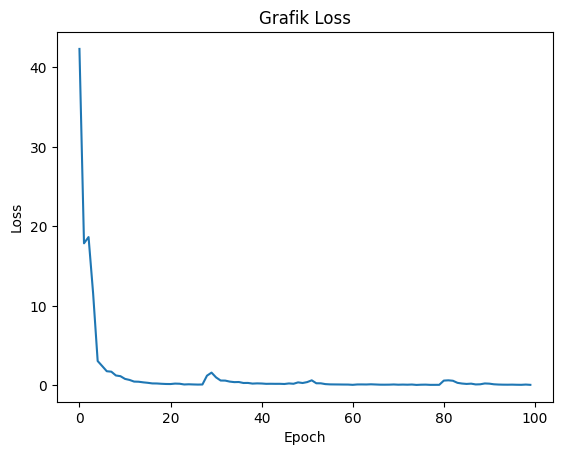

In [75]:
plt.plot(loss_all)
plt.title('Grafik Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [77]:
model.eval() #mode evaluasi
total_correct = 0
total_samples = 0
with torch.no_grad():
  for batch, (src, trg) in enumerate(test_data):
    src = src.permute(0, 3, 1, 2)
    # Forward pass
    pred = model(src).to(device)
    # Hitung jumlah prediksi yang benar
    total_correct += (torch.argmax(pred, dim=1) == torch.argmax(trg, dim=1)).sum().item()
    total_samples += trg.size(0)
accuracy = total_correct / total_samples
print(f'Test sample: ', total_samples)
print(f'Test correct: ', total_correct)
print(f'Test Accuracy: {accuracy * 100:.2f}%')

Test sample:  12
Test correct:  5
Test Accuracy: 41.67%
